# Computational Social Science Project #2 

*Group number:* 8

*Group members:* Song, Jiyoung | Amerkhanian, Peter | Jiang, Qi

*Semester:* Fall 2022


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send KQ a pull request on GitHub flagging the syntax that's tripping you up 

## 1. Introduction/Setup

#### a) Import relevant libraries
Add the other libraries you need for your code below and/or as you go. 

In [1]:
# import libraries you might need here 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. 

In [2]:
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       #CountyFips needs to be a string so leading 0 isn't dropped (this is only if you want to make choropleth map): 
                       dtype={"CountyFIPS": str}) 

In [3]:
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
pd.set_option('display.max_rows', 100) # tells pandas how many rows to display when printing so results don't get truncated

# look at the data types for each column in diabetes df 
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [6]:
# Now do the same as above, but for "Obesity_Number" :
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique())

['No Data']


The values contained in the two columns above making them objects (rather than integers) appear to be strings like "No Data" and "Suppressed." Let's drop those rows in the next section, and also recode Physical_Inactivity_Number to be an integer. 

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' to. 

In [7]:
# Diabetes
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int)

# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int)


# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]
# change to numeric (specifically, integer or float?) from string (because originally included the "-" )
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [8]:
# select count variables to rc to percentages; make sure we leave out ratios and our population variable b/c these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'sex and age_total population_sex ratio (males per 100 females)', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') # recode all selected columns to numeric

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [9]:
pd.set_option('display.max_columns', None)
# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

count           mean  \
Diabetes_Number                                     3112.0       0.092857   
Obesity_Number                                      3112.0       0.251666   
Physical_Inactivity_Number                          3112.0       0.200861   
sex and age_total population_65 years and over_...  3112.0      84.275643   
race_total population                               3112.0  103682.624036   
race_total population_one race                      3112.0       0.976059   
race_total population_two or more races             3112.0       0.023941   
race_total population_one race_1                    3112.0       0.976059   
race_total population_one race_white                3112.0       0.831107   
race_total population_one race_black or african...  3112.0       0.090215   
race_total population_one race_american indian ...  3112.0       0.019398   
race_total population_one race_american indian ...  3112.0       0.001791   
race_total population_one race_american indian ...  3112.0       0.001338   
race_total population_one race_american indian ...  3112.0       0.001229   
race_total population_one race_american indian ...  3112.0       0.003315   
race_total population_one race_asian                3112.0       0.013749   
race_total population_one race_asian_asian indian   3112.0       0.002628   
race_total population_one race_asian_chinese        3112.0       0.002644   
race_total population_one race_asian_filipino       3112.0       0.002744   
race_total population_one race_asian_japanese       3112.0       0.000707   
race_total population_one race_asian_korean         3112.0       0.001174   
race_total population_one race_asian_vietnamese     3112.0       0.001255   
race_total population_one race_asian_other asian    3112.0       0.002598   
race_total population_one race_native hawaiian ...  3112.0       0.000874   
race_total population_one race_native hawaiian ...  3112.0       0.000303   
race_total population_one race_native hawaiian ...  3112.0       0.000142   
race_total population_one race_native hawaiian ...  3112.0       0.000134   
race_total population_one race_native hawaiian ...  3112.0       0.000295   
race_total population_one race_some other race      3112.0       0.020716   
race_total population_two or more races_1           3112.0       0.023941   
race_total population_two or more races_white a...  3112.0       0.006444   
race_total population_two or more races_white a...  3112.0       0.008618   
race_total population_two or more races_white a...  3112.0       0.003021   
race_total population_two or more races_black o...  3112.0       0.000652   
race alone or in combination with one or more o...  3112.0       1.000000   
race alone or in combination with one or more o...  3112.0       0.852907   
race alone or in combination with one or more o...  3112.0       0.098875   
race alone or in combination with one or more o...  3112.0       0.029923   
race alone or in combination with one or more o...  3112.0       0.018213   
race alone or in combination with one or more o...  3112.0       0.002067   
race alone or in combination with one or more o...  3112.0       0.023626   
hispanic or latino and race_total population        3112.0       1.000000   
hispanic or latino and race_total population_hi...  3112.0       0.093201   
hispanic or latino and race_total population_hi...  3112.0       0.069331   
hispanic or latino and race_total population_hi...  3112.0       0.005656   
hispanic or latino and race_total population_hi...  3112.0       0.001568   
hispanic or latino and race_total population_hi...  3112.0       0.016645   
hispanic or latino and race_total population_no...  3112.0       0.906799   
hispanic or latino and race_total population_no...  3112.0       0.765065   
hispanic or latino and race_total population_no...  3112.0       0.088817   
hispanic or latino and race_total population_no...  3112.0       0.018016   
hispanic or latino and race_total population_no..

#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. 

In [10]:
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population_65 years and over_1',
 'sex and age_total population_18 years and over_1',
 'hispanic or latino and race_total population',
 'race_total population_two or more races_1',
 'race_total population_one race_1',
 'sex and age_total population']

In [11]:
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 
diabetes.shape

(3112, 89)

## 2. Exploratory Data Analysis

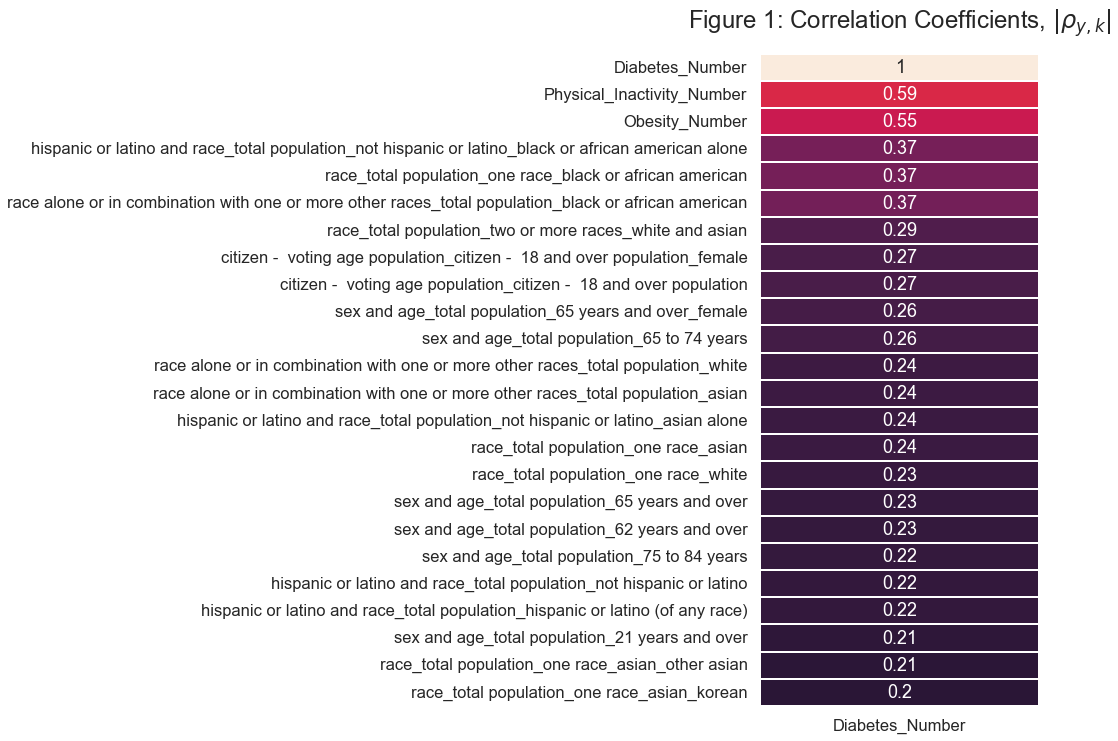

In [12]:
### By Peter
sns.set(context="talk")
abs_correlations = (diabetes.corr()[[
    'Diabetes_Number'
]].fillna(0).abs())
fig, ax = plt.subplots(1, 1, figsize=(5, 12))
sns.heatmap(
    (abs_correlations.query("Diabetes_Number >= .2").sort_values(by="Diabetes_Number", ascending=False)),
    ax=ax,
    cbar=False,
    cbar_kws={"location": "bottom"},
    linewidths=.2,
    vmin=.1,
    annot=True)
ax.set_title(r"Figure 1: Correlation Coefficients, $|\rho_{y,k}|$",
             size=24,
             y=1.03);

**Figure 1** allows us to examine how every feature in the dataset co-varies with our outcome, `Diabetes_Number`. This is important because when we do feature selection, we want to make sure that the features we use are in some way associated with or else influence the outcome. We can see that various demographic characteristics are associated - negatively or positively - with the Diabetes rate, and including them will likely make our model more robust.

In [13]:
### By Peter
pop_mean = diabetes['Diabetes_Number'].mean()
states = (
    diabetes
    .groupby("State")['Diabetes_Number']
    .agg([np.mean, np.std])
    .assign(z_score= lambda x: (x['mean'] - pop_mean) / x['std'])
    .dropna()
    .sort_values(by="z_score",
                 ascending=False)
)

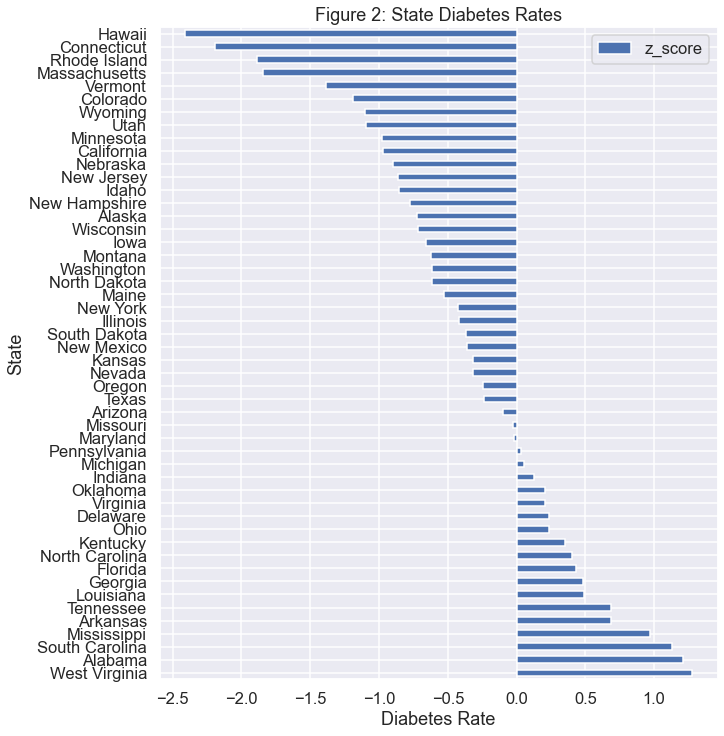

In [14]:
### By Peter
sns.set(context="talk")
fig, axes = plt.subplots(1, 1, figsize=(10, 12))
states['z_score'].plot(kind="barh", ax=axes);
axes.legend()
axes.set_xlabel("Diabetes Rate")
axes.set_title("Figure 2: State Diabetes Rates");

**Figure 2** allows us to examine how the Diabetes rate varies conditional on different states. We can immediately see that there are states in the Southeastern U.S. with very high diabetes rates. Given this, including some sort of information about geography in our model will likely improve predictions.

C:\Users\PETERA~2\AppData\Local\Temp/ipykernel_18548/2732811216.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar().set_label("Male", fontsize=12)


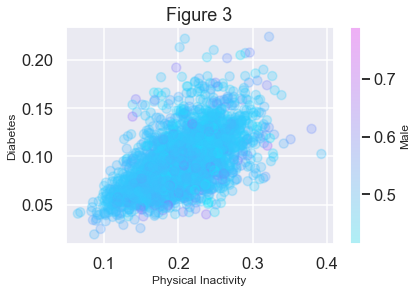

In [15]:
plt.scatter(diabetes["Physical_Inactivity_Number"], 
            diabetes["Diabetes_Number"],
            marker = "o",
            alpha = 0.25,
            c = diabetes["sex and age_total population_male"],
            cmap = "cool")
plt.xlabel("Physical Inactivity", fontsize = 12)
plt.ylabel("Diabetes", fontsize = 12)
plt.colorbar().set_label("Male", fontsize=12)
plt.title("Figure 3");

**Figure 3** shows that there appears to be a strong relationship between diabetes and physical inactivity. Higher levels of physical inactivity are associated with higher levels of diabetes. It is not fully clear from the figure whether the proportion of male-identifying individuals in the county is associated with levels of physical inactivity or diabetes.

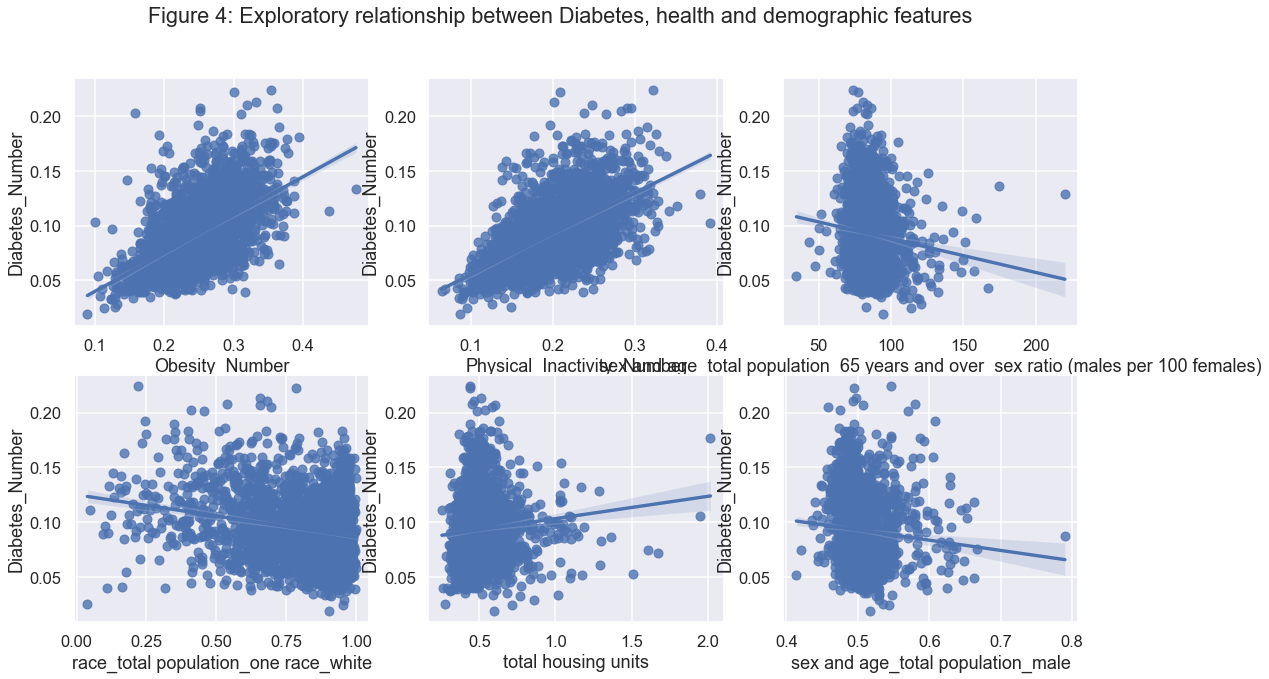

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle("Figure 4: Exploratory relationship between Diabetes, health and demographic features")
sns.regplot(ax=axes[0,0], x="Obesity_Number", y="Diabetes_Number", data=diabetes)
sns.regplot(ax=axes[0,1], x="Physical_Inactivity_Number", y="Diabetes_Number", data=diabetes)
sns.regplot(ax=axes[0,2], x="sex and age_total population_65 years and over_sex ratio (males per 100 females)", y="Diabetes_Number", data=diabetes)
sns.regplot(ax=axes[1,0], x="race_total population_one race_white", y="Diabetes_Number", data=diabetes)
sns.regplot(ax=axes[1,1], x="total housing units", y="Diabetes_Number", data=diabetes)
sns.regplot(ax=axes[1,2], x="sex and age_total population_male", y="Diabetes_Number", data=diabetes);

After drawing lines between diabete numbers and major health as well as demographic information in **Figure 4**, we can see: 
- obesity and physical inactivity seems to be strongly associated with diabetes, with very small confendential intervals.
- demographic information, including age, gender, race, and assets, is also important to predict diabetes.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'State' to be a categorical variable using `pd.get_dummies` and drop 'County' using `.drop()` because 'CountyFIPS' is already a unique identifier for the county. 

In [17]:
diabetes

County    State CountyFIPS  Diabetes_Number  Obesity_Number  \
0        Autauga County  Alabama      01001         0.093804        0.244366   
1        Baldwin County  Alabama      01003         0.080281        0.233255   
2        Barbour County  Alabama      01005         0.131875        0.310643   
3           Bibb County  Alabama      01007         0.105251        0.290052   
4         Blount County  Alabama      01009         0.108977        0.246804   
...                 ...      ...        ...              ...             ...   
3215  Sweetwater County  Wyoming      56037         0.058028        0.212208   
3216       Teton County  Wyoming      56039         0.019038        0.088946   
3217       Uinta County  Wyoming      56041         0.069872        0.238973   
3218    Washakie County  Wyoming      56043         0.078361        0.213802   
3219      Weston County  Wyoming      56045         0.084648        0.283803   

      Physical_Inactivity_Number  \
0                       0.226902   
1                       0.192324   
2                       0.210651   
3                       0.258667   
4                       0.249198   
...                          ...   
3215                    0.170410   
3216                    0.086951   
3217                    0.170751   
3218                    0.210112   
3219                    0.194789   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                                  76.5                                  
1                                                  86.6                                  
2                                                  76.2                                  
3                                                  80.5                                  
4                                                  79.7                                  
...                                                 ...                                  
3215                                               92.0                                  
3216                                               94.8                                  
3217                                               97.6                                  
3218                                               89.0                                  
3219                                               90.6                                  

      race_total population  race_total population_one race  \
0                     55200                        0.981341   
1                    208107                        0.982836   
2                     25782                        0.986308   
3                     22527                        0.991699   
4                     57645                        0.983780   
...                     ...                             ...   
3215                  44117                        0.979804   
3216                  23059                        0.992020   
3217                  20609                        0.965161   
3218                   8129                        0.958420   
3219                   7100                        0.979718   

      race_total population_two or more races  \
0                                    0.018659   
1                                    0.017164   
2                                    0.013692   
3                                    0.008301   
4                                    0.016220   
...                                       ...   
3215                                 0.020196   
3216                                 0.007980   
3217                                 0.034839   
3218                                 0.041580   
3219                                 0.020282   

      race_total population_one race_white  \
0                                 0.768786   
1                                 0.862662   
2                                 0.473819   
3           

In [18]:
# create dummy features out of 'State' , which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['State', 'CountyFIPS'],  
                               drop_first = True) # only create 49 dummies by dropping first in category

# drop 'County' variable
diabetes_clean = diabetes_clean.drop(labels = ['County'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

Diabetes_Number  Obesity_Number  Physical_Inactivity_Number  \
0         0.093804        0.244366                    0.226902   
1         0.080281        0.233255                    0.192324   
2         0.131875        0.310643                    0.210651   
3         0.105251        0.290052                    0.258667   
4         0.108977        0.246804                    0.249198   
5         0.224208        0.353748                    0.321967   
6         0.145318        0.349513                    0.300974   
7         0.127648        0.298580                    0.234140   
8         0.141518        0.324425                    0.220570   
9         0.122848        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.205703          
8                                           0.393750          
9                                           0.

In [19]:
drop_col = diabetes_clean.T[diabetes_clean.var() <= 0].index[0]
features = diabetes_clean.drop(['Diabetes_Number', drop_col], axis=1)

### 3.2/3.3 Partition Data and Feature Selection

Now, we will partition our data to prepare it for the training process. We will use 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

In [20]:
from sklearn.model_selection import train_test_split

# Set y 
y = diabetes_clean['Diabetes_Number']

# X (everything except diabetes, our target)
X = diabetes_clean.drop(['Diabetes_Number'], axis=1)

We should also preprocess our data. Using the `preprocessing` module from sklearn, let's scale our features so that they are mean-centered.

In [21]:
X = preprocessing.scale(X)
X.shape

(3112, 3246)

We can also get rid of the 0 variance features using the `VarianceThreshold()` method from `feature_selection`. 

In [22]:
X

array([[-1.64718728e-01,  5.85154826e-01, -7.51555953e-01, ...,
        -1.79287493e-02, -1.79287493e-02, -1.79287493e-02],
       [-4.15441098e-01, -1.91814864e-01,  2.24661119e-01, ...,
        -1.79287493e-02, -1.79287493e-02, -1.79287493e-02],
       [ 1.33084974e+00,  2.19986785e-01, -7.80552499e-01, ...,
        -1.79287493e-02, -1.79287493e-02, -1.79287493e-02],
       ...,
       [-2.86406519e-01, -6.76572169e-01,  1.28786783e+00, ...,
         5.57763391e+01, -1.79287493e-02, -1.79287493e-02],
       [-8.54395661e-01,  2.07877754e-01,  4.56633493e-01, ...,
        -1.79287493e-02,  5.57763391e+01, -1.79287493e-02],
       [ 7.25189080e-01, -1.36435402e-01,  6.11281741e-01, ...,
        -1.79287493e-02, -1.79287493e-02,  5.57763391e+01]])

In [23]:
from sklearn import feature_selection

selector = feature_selection.VarianceThreshold(0)
X = selector.fit_transform(X)

In [24]:
X.shape

(3112, 3245)

And finally, let's split our data:

In [25]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6, test_size=.4)

X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, train_size=.5, test_size=.5)

## Checking the sizes:

In [26]:
print("Train", X_train.shape[0] / X.shape[0])
X_train.shape[0]

Train 0.5999357326478149


1867

In [27]:
print("Val", X_validate.shape[0] / X.shape[0])
X_validate.shape[0]

Val 0.20019280205655526


623

In [28]:
print("Test", X_test.shape[0] / X.shape[0])
X_test.shape[0]

Test 0.19987146529562982


622

## 4. Train Models

In [29]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [30]:
# ElasticNet
elasticnet_reg = ElasticNet(l1_ratio=.5, max_iter=100000)
elasticnet_model = elasticnet_reg.fit(X_train, y_train)
# Ridge
ridge_reg = Ridge()
ridge_model = ridge_reg.fit(X_train, y_train)
# LASSO
lasso_reg = Lasso(max_iter=10000)
lasso_model = lasso_reg.fit(X_train, y_train)

In [31]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual)**2))

def display_rmse(X, y, group):
    for model in zip([elasticnet_model, ridge_model, lasso_model],
                 ['Elastic Net', 'Ridge', 'Lasso']):
        result = rmse(model[0].predict(X), y)
        print(model[1], f"{group} RMSE:", result)

In [32]:
display_rmse(X_train, y_train, "Training")

Elastic Net Training RMSE: 0.028265809392299165
Ridge Training RMSE: 7.65883357265213e-06
Lasso Training RMSE: 0.028265809392299165


After initially fitting the models to the training data, we proceed to test different hyper-parameter specifications, specifically changing the penalty term $\alpha$ to be smaller. This yields good results: 

In [33]:
# LASSO
lasso_reg = Lasso(max_iter=1000, alpha=0.0001)
lasso_model = lasso_reg.fit(X_train, y_train)

c:\users\peteramerkhanian\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.267e-04, tolerance: 1.492e-04
  model = cd_fast.enet_coordinate_descent(


In [34]:
# ElasticNet
elasticnet_reg = ElasticNet(l1_ratio=.1, max_iter=100000, alpha=0.0001)
elasticnet_model = elasticnet_reg.fit(X_train, y_train)

In [35]:
# Ridge
ridge_reg = Ridge(alpha=0.0001)
ridge_model = ridge_reg.fit(X_train, y_train)

In [36]:
display_rmse(X_train, y_train, "Training")

Elastic Net Training RMSE: 0.00033104807262646275
Ridge Training RMSE: 7.866571791972108e-10
Lasso Training RMSE: 0.0031359176341877867


## 5. Validate and Refine Models

### 5.1 Predict on the Validation Set
Using each of the models you trained, predict outcomes in the validation set.
Evaluate how well each model did.

In [37]:
display_rmse(X_validate, y_validate, "Validation")

Elastic Net Validation RMSE: 0.020731005626313668
Ridge Validation RMSE: 0.021757471954579808
Lasso Validation RMSE: 0.020747479585083203


### 5.2 Feature Selection
Conduct feature selection using techniques specific to these models. For instance, you might use coefficient cutoffs or variable importance plots. If you
used a model that does automatic feature selection, detail those results as well.

In [38]:
coefficients = pd.DataFrame([lasso_model.coef_, ridge_model.coef_, elasticnet_model.coef_]).T
coefficients.index = features.columns
names = ['Lasso', 'Ridge', 'ElasticNet']
coefficients.columns = names
coefficients = coefficients.abs()

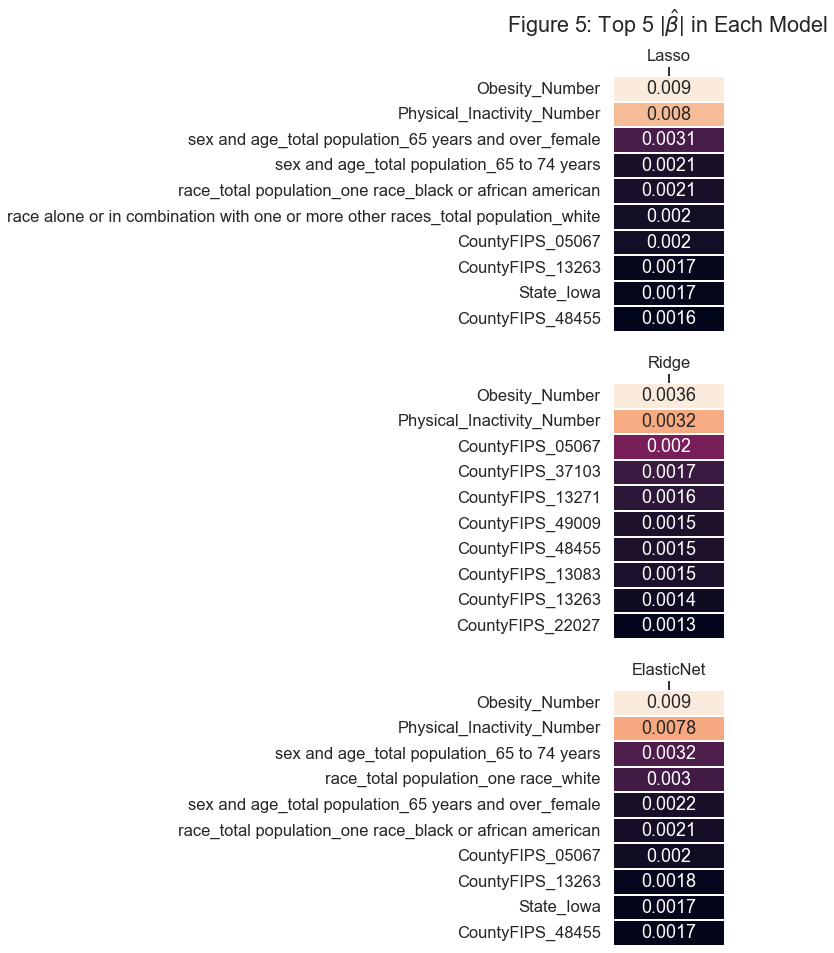

In [39]:
sns.set(context="talk")
fig, axes = plt.subplots(3, 1, figsize=(2, 16), sharey=False)
fig.suptitle(r"Figure 5: Top 5 |$\hat{\beta}$| in Each Model", y=.94)
for i in range(3):
    sns.heatmap(
    coefficients[[names[i]]].sort_values(by=names[i], ascending=False).head(10),
    ax=axes[i],
    cbar=False,
    cbar_kws={"location": "bottom"},
    linewidths=.2,
    annot=True)
    axes[i].xaxis.tick_top()

In [40]:
for model in coefficients.columns:
    print(model)
    print((coefficients <= 0)[model].value_counts().rename({True: 'Dropped Features', False: 'Kept Features'}), "\n")

Lasso
Dropped Features    1679
Kept Features       1566
Name: Lasso, dtype: int64 

Ridge
Kept Features    3245
Name: Ridge, dtype: int64 

ElasticNet
Kept Features       1838
Dropped Features    1407
Name: ElasticNet, dtype: int64 



**Interpretation:**  
Each of the penalized regression models dropped features - we can see that Lasso dropped the most features. We can also see in **Figure 5** that the models assigned different levels of importance to different variables, with Lasso and Elastic Net placing much more emphasis on the obesity number (which was highly correlated with diabetes), whereas Ridge focused more on racial demographics - the percentage of the population that is Black/Indigenous specifically.


### 5.3 Test Set
Choose your best performing model, select out unimportant features, retrain
the model, and then predict on the test set. Evaluate your performance on this
test set. What is the advantage of using both validation and test sets in the
social sciences and public policy?

In [41]:
# Drop Features that Lasso gave 0 coefficients
new_X = X.T[coefficients['Lasso'] <= 0].T
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, train_size=.8, test_size=.2)

In [42]:
final_lasso_reg = Lasso(max_iter=1000, alpha=0.0001)
final_lasso_model = lasso_reg.fit(new_X_train, new_y_train)

In [43]:
result = rmse(final_lasso_model.predict(new_X_test), new_y_test)
print("Lasso Test RMSE:", result)

Lasso Test RMSE: 0.024037596862947465


**Discussion:**  
We use the validation set to tune hyperparameters, evaluate the performance of each model, choose the model that performed best, and finally fit the chosen model to the test dataset. Using a validation set can be helpful to prevent overfitting because the bias is guaranteed to be smaller in the training set than in the validation set. Furthermore, a separate test set can help us to evaluate the performance of chosen model in an unbiased manner in previously unseen data. 

### 5.4 Implement a Cross-Validation Approach
Do the following:  
- Using your preferred model, use a k-fold cross-validation approach to refit
the model.
- Describe the tradeoffs involved with the choice of k.
- Evaluate the results. How did cross-validation do compared to the train/validation/test split?


In [45]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# ElasticNet
elasticnet_reg = ElasticNet(max_iter=100000)
# Ridge
ridge_reg = Ridge()
# LASSO
lasso_reg = Lasso(max_iter=10000)

print("************")
print("Elastic Net")
# Elastic Net
param_grid = {'alpha': np.arange(.1, .4, .1), 'l1_ratio': np.arange(.1, 1, .1)}
elasticnet_grid_reg = GridSearchCV(elasticnet_reg, param_grid, cv=3)
elasticnet_grid_reg.fit(X_train, y_train)
best_index = np.argmax(elasticnet_grid_reg.cv_results_["mean_test_score"])
best_elasticnet_pred = elasticnet_grid_reg.best_estimator_.predict(X_validate)
print(elasticnet_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(elasticnet_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', elasticnet_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_elasticnet_pred, y_validate))

# Ridge
print("************")
print("Ridge")
param_grid = {
    'alpha': np.arange(.1, .4, .1),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}
ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3)
ridge_grid_reg.fit(X_train, y_train)
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

# LASSO
print("************")
print("Lasso")
param_grid = {
    'alpha': np.arange(.1, .4, .1)
}
lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3)
lasso_grid_reg.fit(X_train, y_train)
best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

************
Elastic Net
{'alpha': 0.1, 'l1_ratio': 0.1}
Best CV R^2: 0.2517995883368233
Validation R^2: 0.2557436078672717
Validation RMSE 0.02511955891743781
************
Ridge
{'alpha': 0.1, 'solver': 'lsqr'}
Best CV R^2: 0.43037561993753815
Validation R^2: 0.44415090997427653
Validation RMSE 0.021708467817802012
************
Lasso
{'alpha': 0.1}
Best CV R^2: -0.0017396620421605096
Validation R^2: -0.00023919730522692362
Validation RMSE 0.029120756799777724


In [46]:
print("Best Algorithm is Ridge,", ridge_grid_reg.cv_results_["params"][best_index])
print('Test R^2:', ridge_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(ridge_grid_reg.best_estimator_.predict(X_test), y_test))

Best Algorithm is Ridge, {'alpha': 0.1, 'solver': 'auto'}
Test R^2: 0.413023290136903
Test RMSE 0.020270484625439872


**Discussion:** In choosing K for our cross validation, the key trade-off is between accuracy and computing resources. We chose k=3, but if we had chosen a higher number we might have gotten an even better test RMSE. However, this would have taken longer to run, and any gains in accuracy from a bigger K could have been marginal.  

Our results here are that Ridge Regression performs the best. This is unlike our previous results, in which Lasso was the best. The cross-validated Ridge model achieved better test RMSE than the train-validate-test split trained Lasso model.

## 6. Discussion Questions

### 6.1 What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?
- The variance refers to the amount by which the predicted parameters would change if we estimate it using a different training set, whereas the bias refers to the difference between the predicted and real outcomes. The bias-variance tradeoff means that in most of models, the variance will increase while the bias decrease, and vice versa.
- Bias-variance tradeoff exists in most, if not all, machine learning problems because data scientists strive to create accurate (low bias) and generalizable (low variance) models. Specifically, when using machine learning methods to inform public policy, policymakers might also place emphasis on drawing fair and transparent conclusions.

### 6.2 Define overfitting, and why it matters for machine learning. How can we address it?
Overfitting occurs when a model has high variance and thus is most likely ungeneralizable and has high bias when applied to unseen data. We can address overfitting using cross-validation. Through iteratively creating multiple train-test split datasets, cross-validation allows for tuning hyperparameters and identifying a model with the optimal bias-variance tradeoff.

### 6.3 Discuss your Analysis in 2-3 Paragraphs
**Discuss your findings and recommendations. Which counties or regions would
you prioritize for the pilot program? Would your answers change based on
whether you want to take into account certain features such as the race, gender,
or age composition in the county? How confident would you be deploying this
sort of model in a real-world application, why or why not?**  

In [54]:
coefficients = pd.DataFrame([ridge_grid_reg.best_estimator_.coef_]).T
coefficients.index = features.columns
names = ['Lasso']
coefficients.columns = names
coefficients['abs'] = coefficients['Lasso'].abs()
coefficients = coefficients.sort_values(by="Lasso",
                                        ascending=False).reset_index()
coefficients['geo'] = coefficients['index'].str.contains(
    "County") + coefficients['index'].str.contains("State")

In [55]:
top10 = coefficients.query("geo == True").head(10)
top_counties = top10['index'].str.split("_").str[1]
diabetes[diabetes["CountyFIPS"].isin(top_counties)]

County           State CountyFIPS  Diabetes_Number  \
144     Jackson County        Arkansas      05067         0.222119   
427        Dade County         Georgia      13083         0.183275   
470       Jones County         Georgia      13169         0.177876   
516      Talbot County         Georgia      13263         0.202885   
520     Telfair County         Georgia      13271         0.207757   
1126  Claiborne Parish       Louisiana      22027         0.201944   
1941      Jones County  North Carolina      37103         0.213306   
2690       Gray County           Texas      48179         0.158475   
2828    Trinity County           Texas      48455         0.182579   
2859    Daggett County            Utah      49009         0.176471   

      Obesity_Number  Physical_Inactivity_Number  \
144         0.301190                    0.208824   
427         0.290750                    0.239231   
470         0.258582                    0.222537   
516         0.157103                    0.238476   
520         0.251877                    0.295998   
1126        0.310840                    0.265585   
1941        0.332336                    0.201753   
2690        0.252237                    0.189156   
2828        0.192669                    0.204887   
2859        0.352941                    0.250000   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
144                                                77.5                                  
427                                                79.2                                  
470                                                80.9                                  
516                                                82.2                                  
520                                                76.3                                  
1126                                               83.4                                  
1941                                               80.7                                  
2690                                               80.2                                  
2828                                               93.3                                  
2859                                               88.7                                  

      race_total population  race_total population_one race  \
144                   17225                        0.916575   
427                   16227                        0.976089   
470                   28548                        0.986094   
516                    6378                        0.996080   
520                   16115                        0.993236   
1126                  16153                        0.986256   
1941                   9695                        0.985353   
2690                  22685                        0.975446   
2828                  14569                        0.981673   
2859                    612                        0.982026   

      race_total population_two or more races  \
144                                  0.083425   
427                                  0.023911   
470                                  0.013906   
516                                  0.003920   
520                                  0.006764   
1126                                 0.013744   
1941                                 0.014647   
2690                                 0.024554   
2828                                 0.018327   
2859                                 0.017974   

      race_total population_one race_white  \
144                               0.784673   
427                               0.949467   
470                               0.728247   
516                               0.411101   
520                               0.536829   
1126                              0.457995   
1941                              0.656318   
2690                              0.852413   
2828                             

We would suggest to prioritize the 10 locations above for the pilot program because they have the highest predicted number of diabetes in our model. With regards to considering race, gender, or age composition, we can see that these geographies are almost all majority white, and we would alter this choice in order to better center racial equity. The counties do not seem as lopsided in terms of gender or age, though we could conduct further statistical analysis of these target counties to be more sure. We would be somewhat conservative to deploy this model in a real-world application because the R_square of the chosen model (~0.41) is not large enough, which suggests that there might be important missing features that could well explain diabetes numbers.